In [1]:
import os

import analysis_plotting_helper_functions_c3 as helper
import analysis_utils as utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


In [2]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]
continuous_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", 
                     "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_palette = {'l': colors[1], 's': colors[0]}

In [3]:
cohort = 'cohort_3'
to_analyze = 'full_clean_stitched'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'figures_stitched_2')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/full_clean_stitched
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/figures_stitched_2


# Session based plotting

### load session log

In [4]:
training_session_log = utils.load_session_log(data_folder, 'stitched_training_sessions.csv')

make mouse list

In [5]:
mouse_list = utils.generate_mouse_list(training_session_log)
print(mouse_list)

['RZ018', 'RZ019', 'RZ020', 'RZ021', 'RZ022', 'RZ023', 'RZ024', 'RZ025']


### Add session type 
shoudl be moved to the previous nb

In [6]:
def get_session_tb(all_trials):
    bg_length = all_trials.bg_length.mean()
    if bg_length <= 2:
        session_type = 's'
    elif bg_length > 2:
        session_type = 'l'
    return [session_type, bg_length]

In [7]:
for dir_name in training_session_log.dir:
    all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
    # time waited for all trials
    bg_info = get_session_tb(all_trials)
    training_session_log.loc[training_session_log.dir == dir_name, 
                                ['session_type', 'bg_length']] = bg_info

### checking if there are mixed long and short sessions between the two cohorts

In [8]:
short_list = ['RZ018', 'RZ019', 'RZ022', 'RZ023']
long_list = ['RZ020', 'RZ021', 'RZ024', 'RZ025']

In [22]:
for m in short_list:
    short_df = training_session_log.loc[training_session_log.mouse == m]
    session_type_list = short_df.session_type.unique().tolist()
    if len(session_type_list) == 1:
        print(m)

RZ018
RZ019
RZ022
RZ023


In [23]:
for m in long_list:
    short_df = training_session_log.loc[training_session_log.mouse == m]
    session_type_list = short_df.session_type.unique().tolist()
    if len(session_type_list) == 1:
        print(m)

RZ020
RZ021
RZ024
RZ025


### Plotting functions
should be moved to helper

In [8]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session_num, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [9]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, mouse_list=mouse_list, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session_num",
                 y=column_name,
                 hue="session_type",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [10]:
def generate_trial_type_df(training_session_log):
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == dir_name, 
                                 ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'session_type', 'session_num', 'num_trials', 
                                          'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [12]:
trial_type_df = generate_trial_type_df(training_session_log)

### trial type combined plot

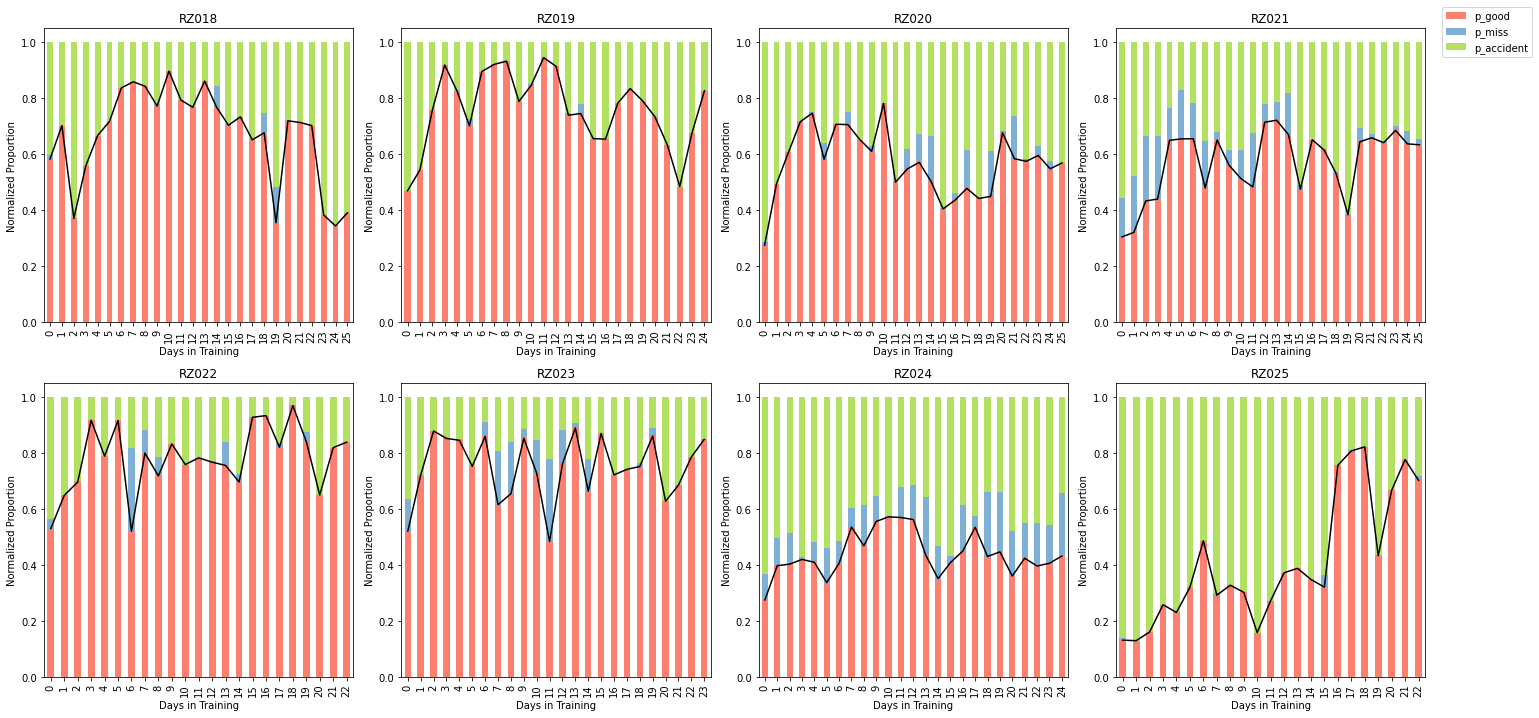

In [13]:
# ploting the proportion of good trials, miss trials, and enl trials per session
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = trial_type_df.loc[trial_type_df.mouse == mouse]
    to_plot = session_mouse.loc[:, ['session_num', 'p_good', 'p_miss', 'p_accident']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='session_num', stacked=True, color=colors[0:3], ax=ax, legend=None)
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.session_num, to_plot.p_good, color='k', linewidth=1.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.07, 1))

plt.tight_layout()
plt.savefig(f'{figure_folder}/engagement_plots.png', bbox_inches='tight')
plt.show()

### percentage good trials

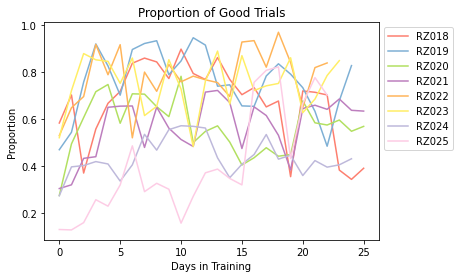

In [14]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

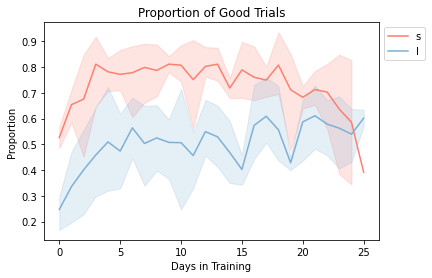

In [15]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

### Percent missed trials

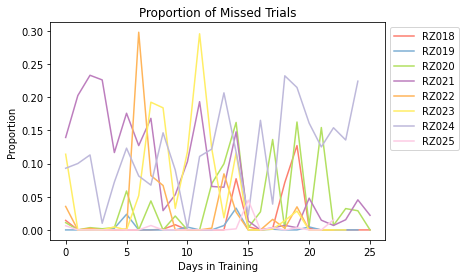

In [16]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Days in Training', 
                         y_label='Proportion')

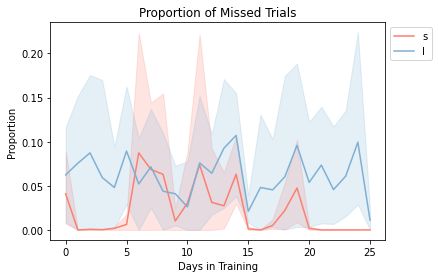

In [17]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

### Percent accident trials

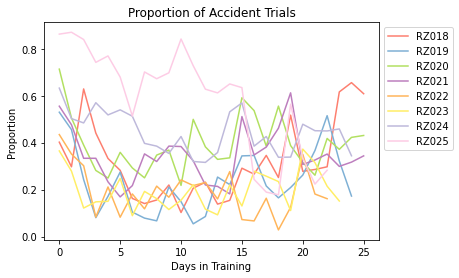

In [18]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Days in Training', 
                         y_label='Proportion')

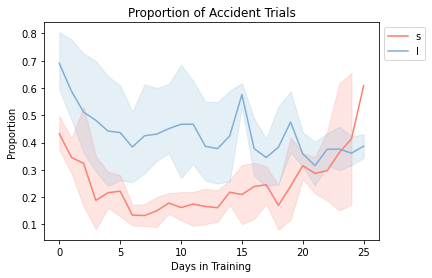

In [19]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Days in Training', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [18]:
training_session_log['reward_rate'] = training_session_log.rewards/training_session_log.time

In [19]:
training_session_log['reward_per_trial'] = training_session_log.rewards/training_session_log.num_trials

### plot reward size

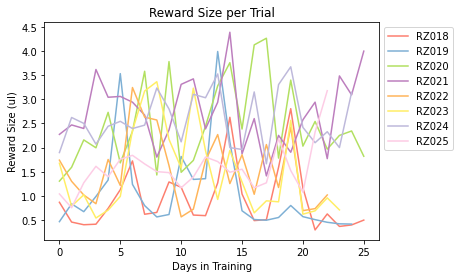

In [20]:
# plot the reward rize
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_per_trial', 
                         plot_name="reward_size",
                         title='Reward Size per Trial', 
                         x_label='Days in Training', 
                         y_label='Reward Size (ul)')

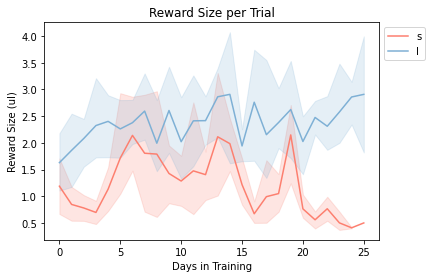

In [21]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_per_trial", 
                               plot_name='reward_size_by_group', 
                               title='Reward Size per Trial', 
                               x_label='Days in Training', 
                               y_label='Reward Size (ul)')

### Plot reward rate

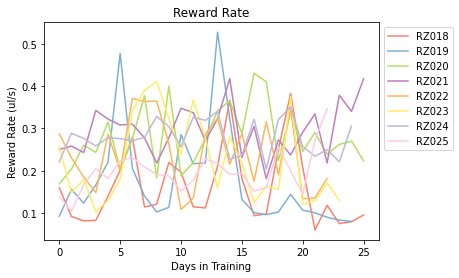

In [22]:
# plot the reward rate
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Days in Training', 
                         y_label='Reward Rate (ul/s)')

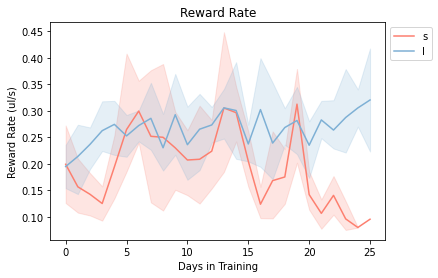

In [23]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Days in Training', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

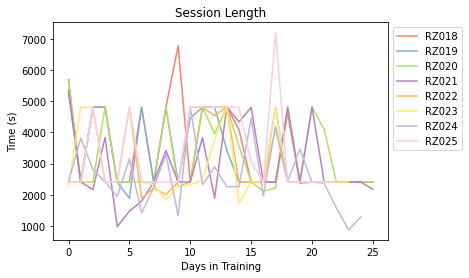

In [24]:
# plot the session length
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Days in Training', 
                         y_label='Time (s)')

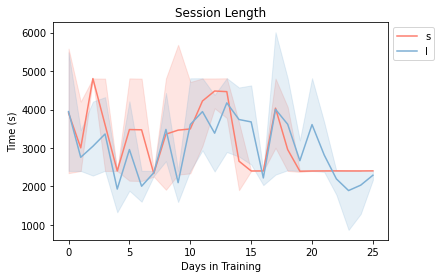

In [25]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

### plot num trials completed

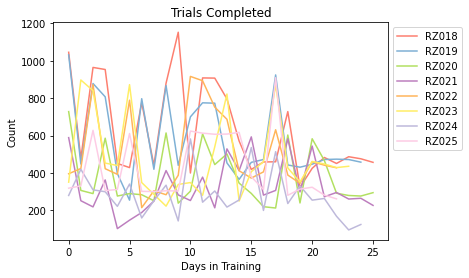

In [26]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=training_session_log, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Days in Training', 
                         y_label='Count')

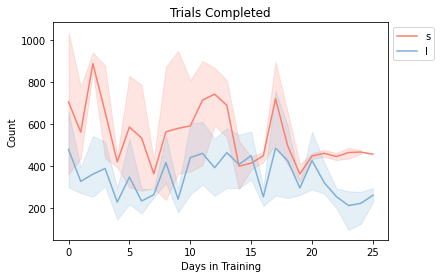

In [27]:
plot_overdays_colored_by_group(data_df=training_session_log, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Days in Training', 
                               y_label='Count')

# Plot time wait behavior

### generate wait df for plotting

In [20]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session_num', 'dir', 'session_type', 'bg_length']].copy()

    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == dir_name, 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [21]:
wait_df = generate_wait_df(training_session_log)

In [12]:
wait_df

mouse  session_num               dir session_type  bg_length   tw_mean  \
0    RZ018            0  2023-07-25_RZ018            s   0.999522  1.361377   
4    RZ018            1  2023-07-26_RZ018            s   0.999791  1.021499   
12   RZ018            2  2023-07-27_RZ018            s   0.998548  0.978895   
20   RZ018            3  2023-07-28_RZ018            s   0.996327  1.031965   
28   RZ018            4  2023-07-30_RZ018            s   0.999113  1.322749   
..     ...          ...               ...          ...        ...       ...   
166  RZ025           18  2023-09-01_RZ025            l   3.003559  2.543143   
174  RZ025           19  2023-09-05_RZ025            l   3.005096  1.633862   
181  RZ025           20  2023-09-06_RZ025            l   2.999691  1.420171   
189  RZ025           21  2023-09-07_RZ025            l   3.028014  2.496791   
197  RZ025           22  2023-09-08_RZ025            l   3.025191  3.074974   

     tw_median  tw_stdev  tw_mean_g  tw_median_g  tw_stdev_g  
0     1.027713  1.349182   1.991995     1.741808    1.275816  
4     0.745497  0.996609   1.576277     1.376724    0.922729  
12    0.565627  1.001398   1.780935     1.741146    0.775037  
20    0.794443  0.983588   1.652953     1.544574    0.833222  
28    1.145049  1.144112   1.859035     1.724915    0.999381  
..         ...       ...        ...          ...         ...  
166   2.508753  1.257609   2.647973     2.550416    1.180251  
174   1.124929  1.663176   2.446655     1.957447    1.541735  
181   0.981286  1.422691   1.996408     1.589362    1.365949  
189   2.401228  1.400749   2.666907     2.503026    1.293127  
197   2.949561  1.369494   3.157244     2.988509    1.295146  

[198 rows x 11 columns]

In [65]:
wait_df_s = wait_df[wait_df.session_type == 's']
wait_df_s.tw_mean.mean()

1.822234754518966

In [66]:
wait_df_l = wait_df[wait_df.session_type == 'l']
wait_df_l.tw_mean.mean()

2.49787543780405

### plot time watied

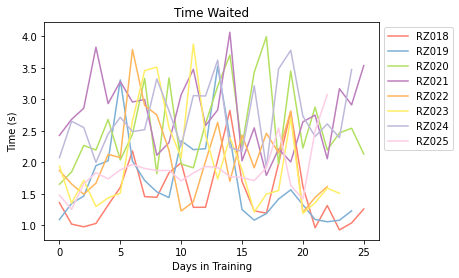

In [22]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Days in Training', 
                         y_label='Time (s)')

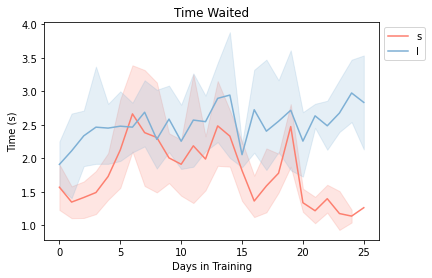

In [23]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Days in Training', 
                               y_label='Time (s)')

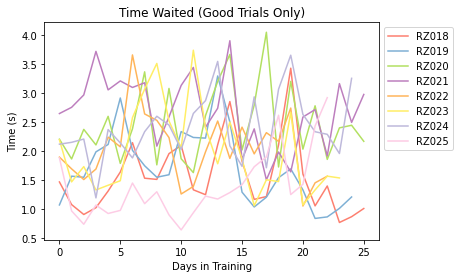

In [24]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Days in Training', 
                         y_label='Time (s)')

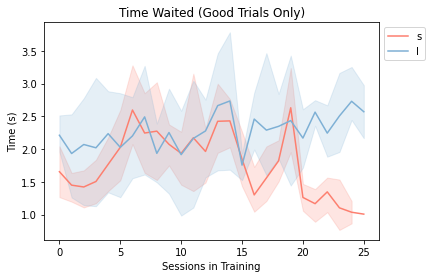

In [25]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions in Training', 
                               y_label='Time (s)')

## some stats

### check if short and long tw are significantly different?
yes for both all trials and good trials only
where should this session go??

In [26]:
short = wait_df[wait_df['session_type']=='s']
long = wait_df[wait_df['session_type']=='l']

#perform independent two sample t-test
ttest_ind(short['tw_mean'], long['tw_mean'])

Ttest_indResult(statistic=-7.191221361716904, pvalue=1.322746277735818e-11)

In [27]:
print(short.tw_mean.mean())
print(long.tw_mean.mean())

1.822234754518966
2.49787543780405


In [28]:
ttest_ind(short['tw_mean_g'], long['tw_mean_g'])

Ttest_indResult(statistic=-4.366489719970786, pvalue=2.042817042037462e-05)

In [29]:
print(short.tw_mean_g.mean())
print(long.tw_mean_g.mean())

1.8145329385553697
2.2636182850481252


### check if boys and girls are significantly different
nope they are not different

In [30]:
boys =  ['RZ018', 'RZ019', 'RZ020', 'RZ021']
girls = ['RZ022', 'RZ023', 'RZ024', 'RZ025']

In [31]:
boy = wait_df[wait_df['mouse'].isin(boys)]
girl = wait_df[wait_df['mouse'].isin(girls)]

ttest_ind(boy['tw_mean_g'], girl['tw_mean_g'])

Ttest_indResult(statistic=1.319893267628885, pvalue=0.18841014381032298)

## linear fit
not so useful for this part

In [32]:
def generate_linear_fit_df(training_session_log):
    linear_fit_df = training_session_log[['mouse', 'session_type', 'session_num', 'dir']].copy()
    for dir_name in training_session_log.dir:
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        all_trials = all_trials[all_trials['time_waited'].notna()]
        fit_data = utils.linear_fit(all_trials, 'bg_length', 'time_waited')
        linear_fit_df.loc[linear_fit_df.dir == dir_name, 
                                ['slope', 'intercept', 'rsquared']] = fit_data
    return linear_fit_df

In [33]:
linear_fit_df = generate_linear_fit_df(training_session_log)

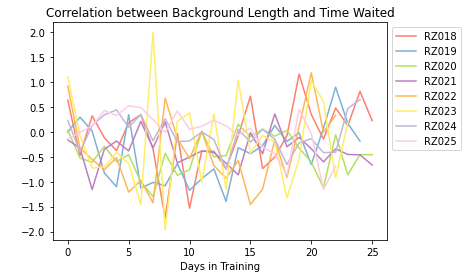

In [34]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=linear_fit_df, 
                         column_name='slope', 
                         plot_name="tb_tw_correlation", 
                         title='Correlation between Background Length and Time Waited',
                         x_label='Days in Training', 
                         y_label=' ')

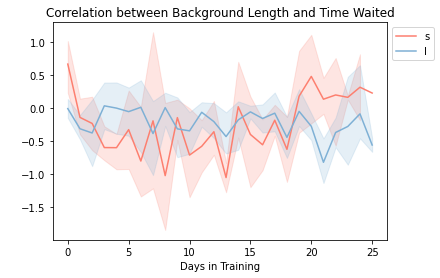

In [35]:
plot_overdays_colored_by_group(data_df=linear_fit_df, 
                               column_name="slope", 
                               plot_name='tb_tw_correlation_by_group', 
                               title='Correlation between Background Length and Time Waited', 
                               x_label='Days in Training', 
                               y_label=' ')

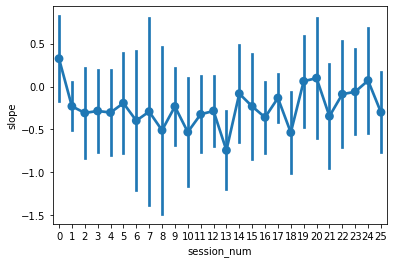

In [36]:
fig = plt.figure()
sns.pointplot(x="session_num", 
              y="slope", 
              errorbar='sd', 
              data=linear_fit_df)
fig.savefig(f'{figure_folder}/tb_tw_correlation_all_mice.png', bbox_inches='tight')

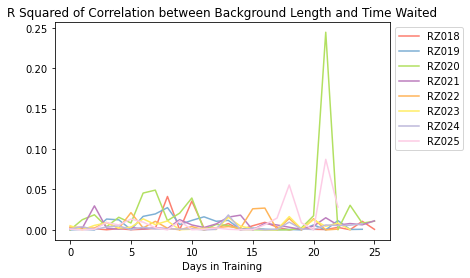

In [37]:
# plot the difference in time waited bewteen long and short blocks over days. good trials only
plot_each_mouse_per_line(data_df=linear_fit_df, 
                         column_name='rsquared', 
                         plot_name="tb_tw_correlation_rsuqared", 
                         title='R Squared of Correlation between Background Length and Time Waited',
                         x_label='Days in Training', 
                         y_label=' ')

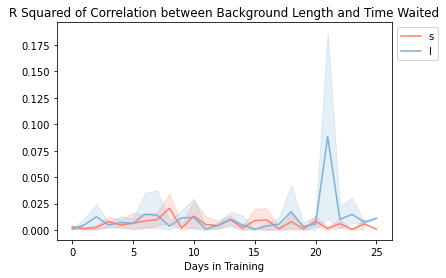

In [38]:
plot_overdays_colored_by_group(data_df=linear_fit_df, 
                               column_name="rsquared", 
                               plot_name='tb_tw_correlation_rsuqared_by_group', 
                               title='R Squared of Correlation between Background Length and Time Waited', 
                               x_label='Days in Training', 
                               y_label=' ')

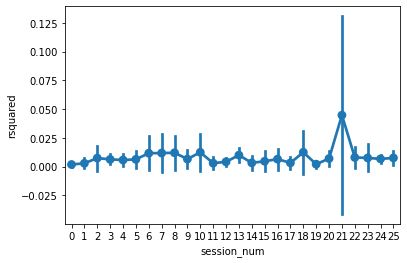

In [39]:
fig = plt.figure()
sns.pointplot(x="session_num", 
              y="rsquared", 
              errorbar='sd', 
              data=linear_fit_df)
fig.savefig(f'{figure_folder}/tb_tw_rsquared_all_mice.png', bbox_inches='tight')

## plots to be figured out

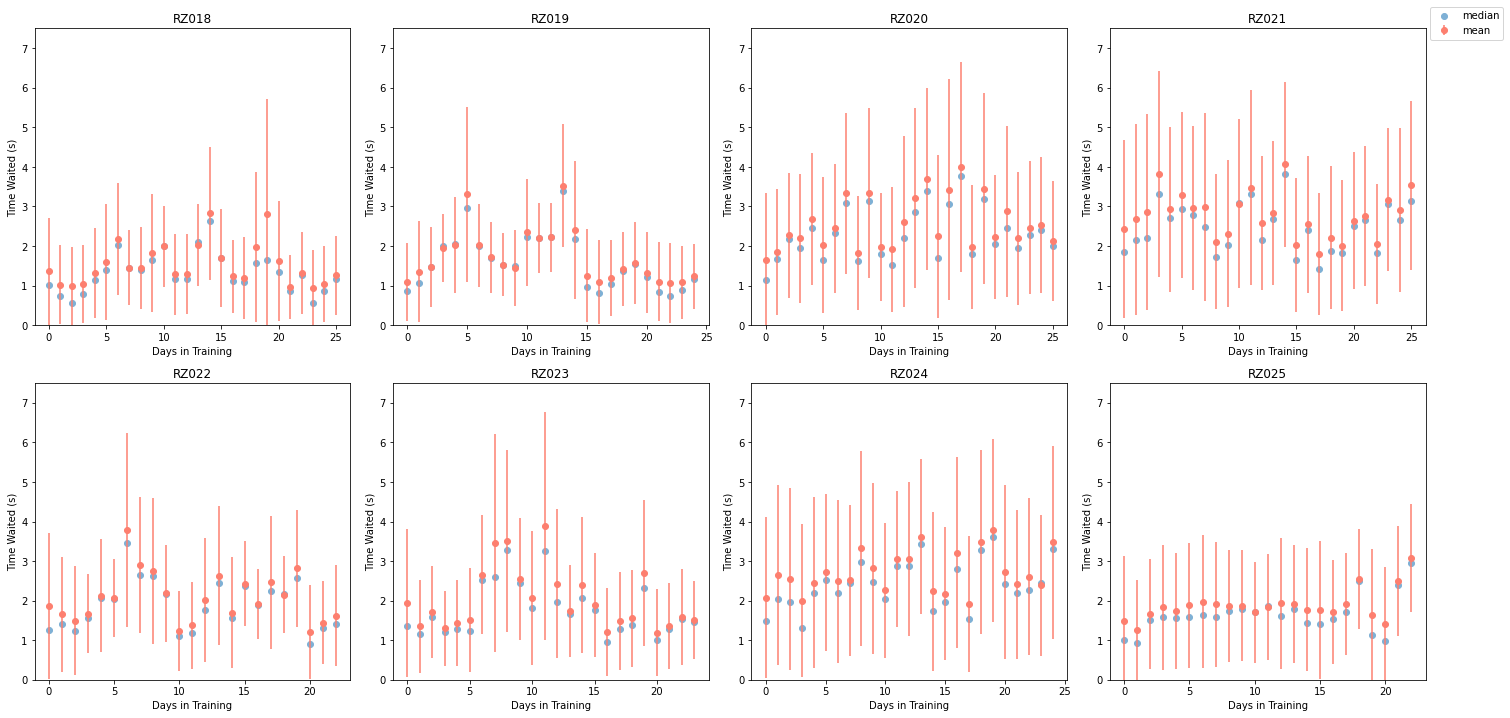

In [40]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.session_num, session_mouse.tw_mean, session_mouse.tw_stdev, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.session_num, session_mouse.tw_median, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time Waited (s)')
    ax.set_ylim(0,7.5)

handles, labels = axs[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.tight_layout()

plt.savefig(f'{figure_folder}/tw_plots.png', bbox_inches='tight', dpi=300)

plt.show()

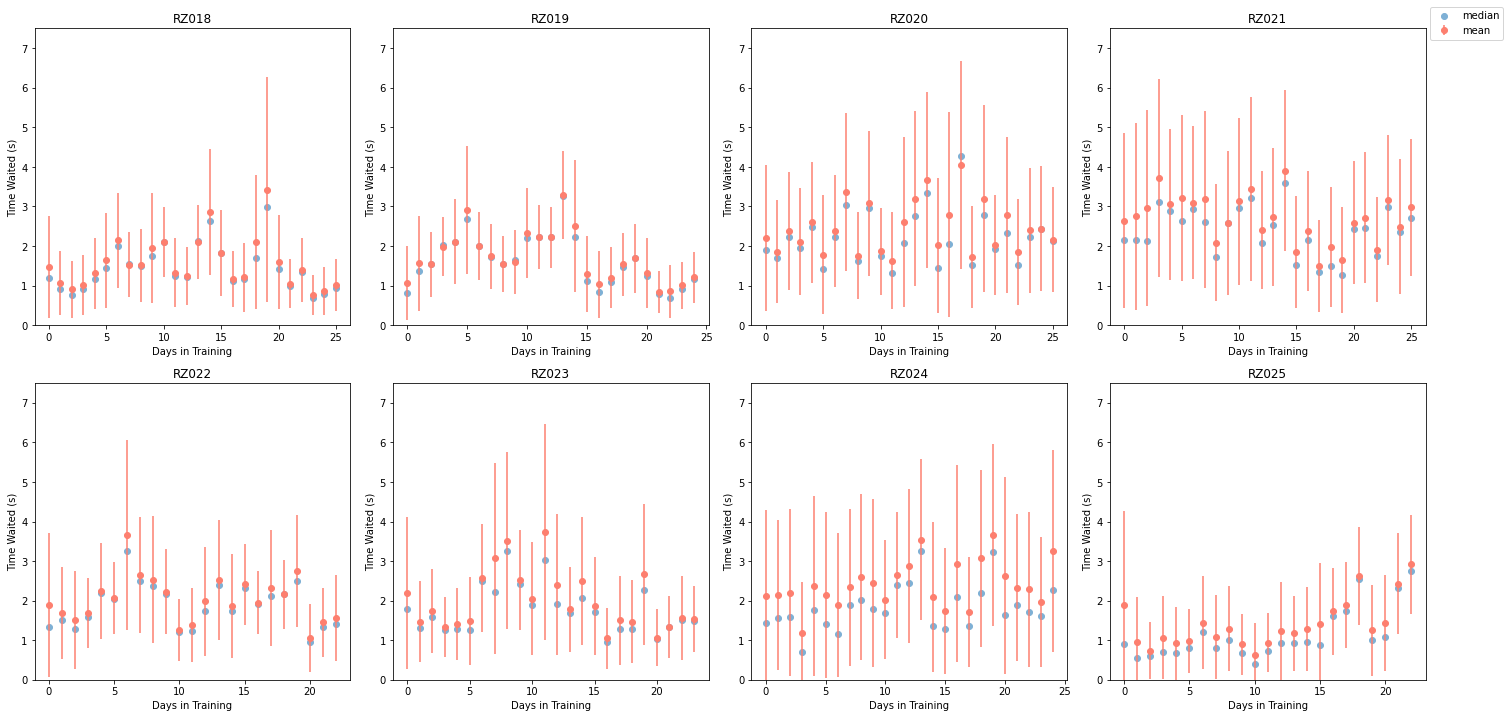

In [41]:
# Create a figure with six subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

# Loop through the mouse list and plot data for each mouse in a subplot
for i, mouse in enumerate(mouse_list):
    session_mouse = wait_df.loc[wait_df.mouse == mouse]
    ax = axs.flat[i]
    ax.errorbar(session_mouse.session_num, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                linestyle='None', marker='o', color=colors[0], label='mean')
    ax.scatter(session_mouse.session_num, session_mouse.tw_median_g, color=colors[1], 
               label='median')
    ax.set_title(mouse)
    ax.set_xlabel('Days in Training')
    ax.set_ylabel('Time Waited (s)')
    ax.set_ylim(0,7.5)

# Extract the legend from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# Set the figure legend outside the loop
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_good_plots.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

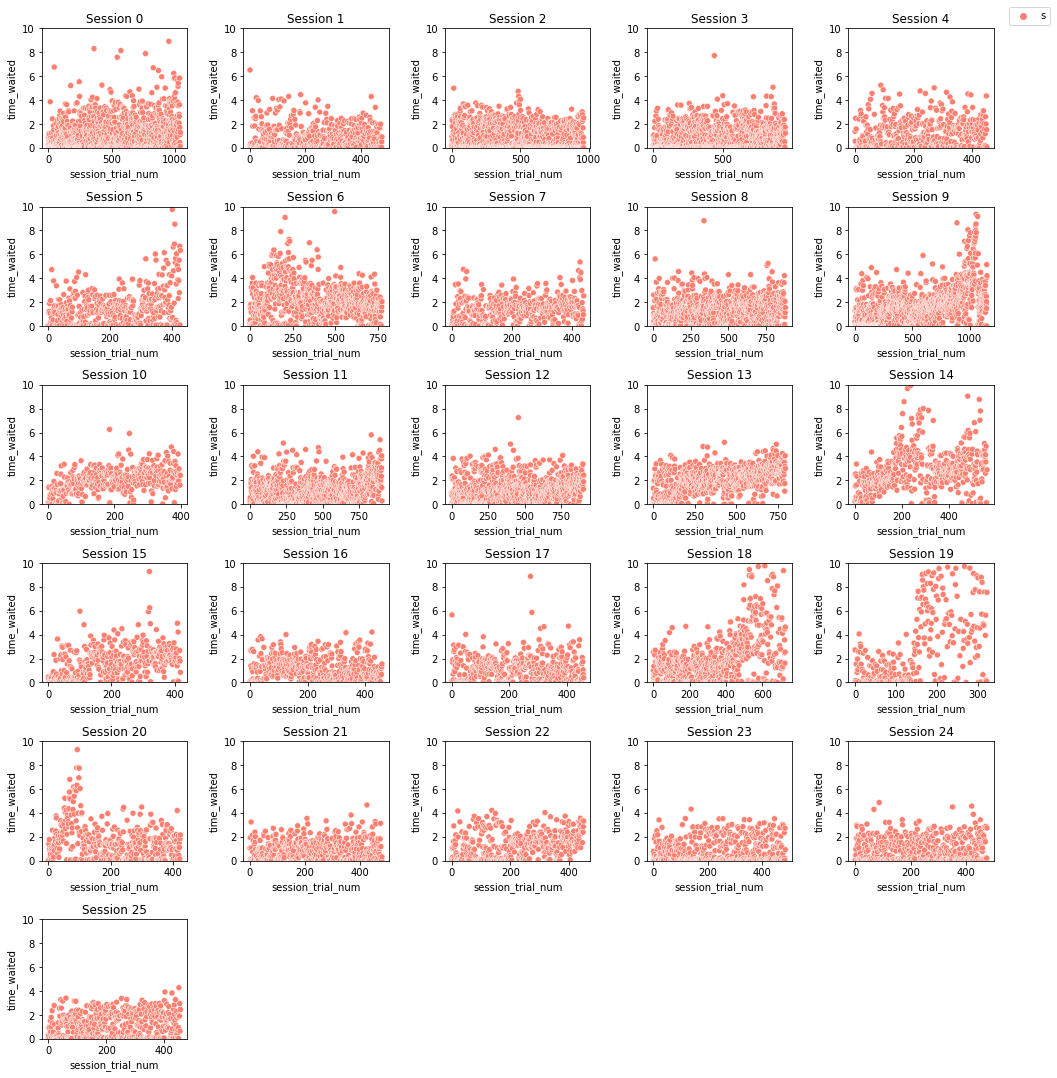

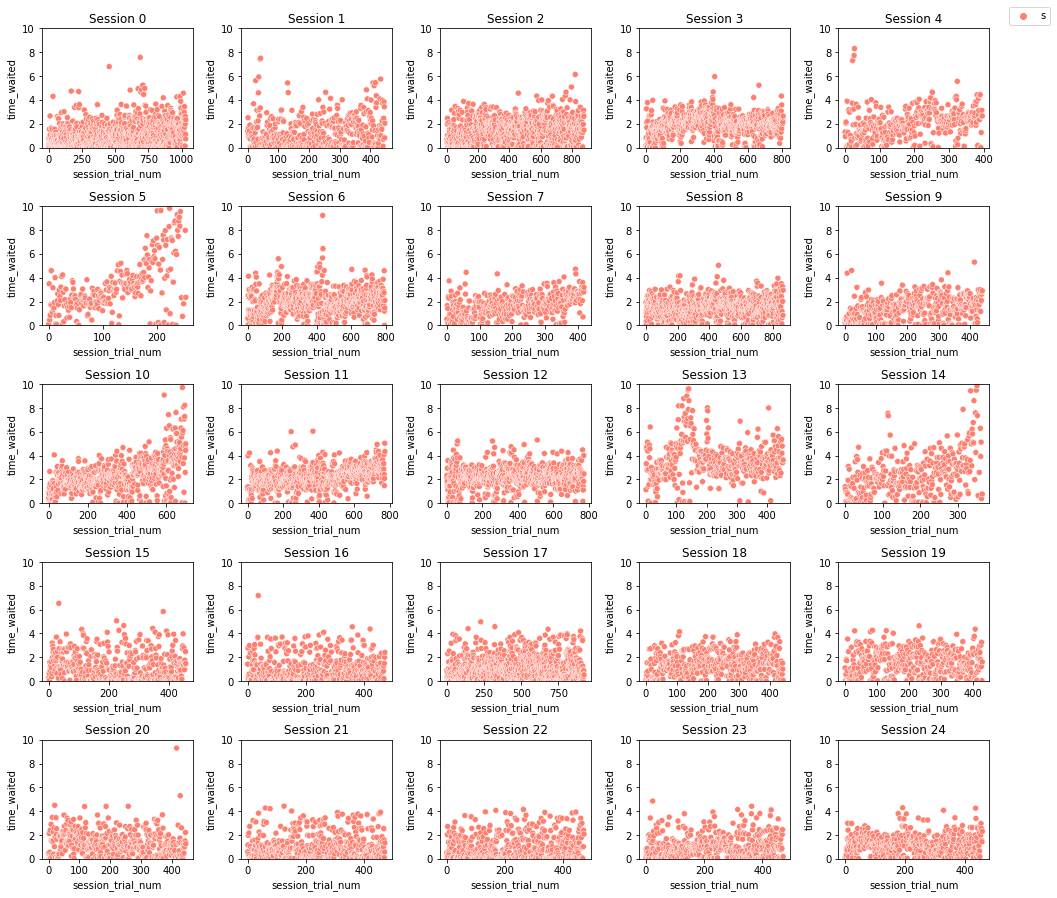

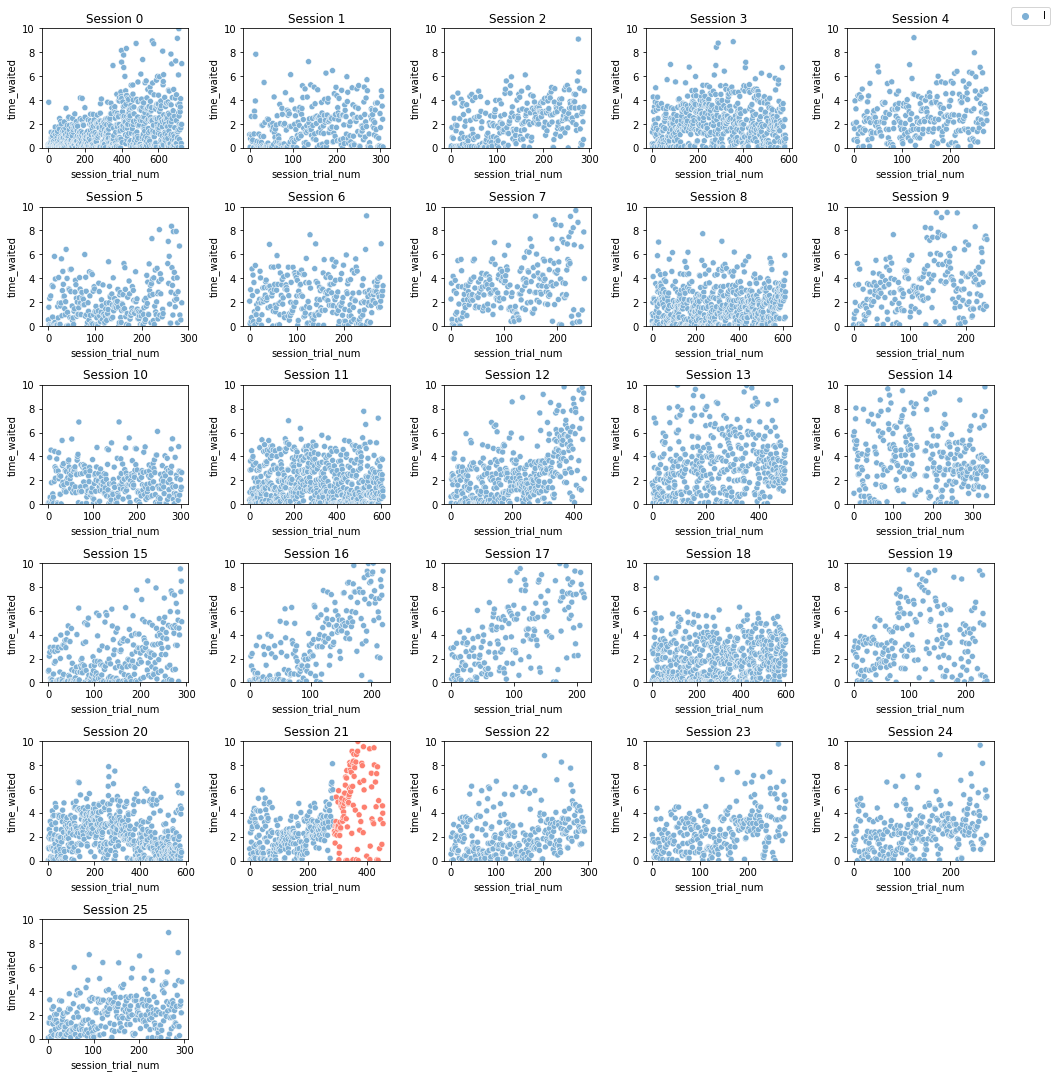

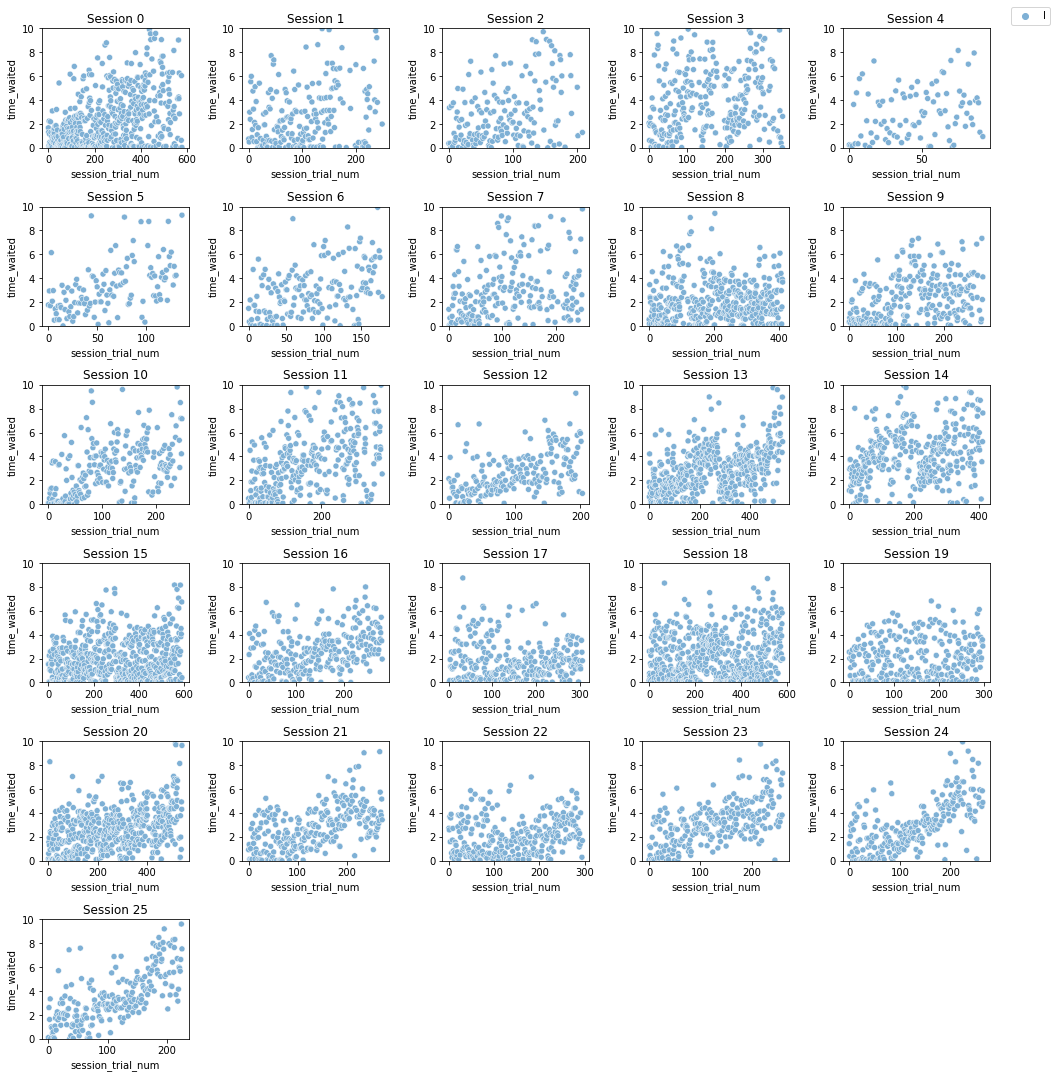

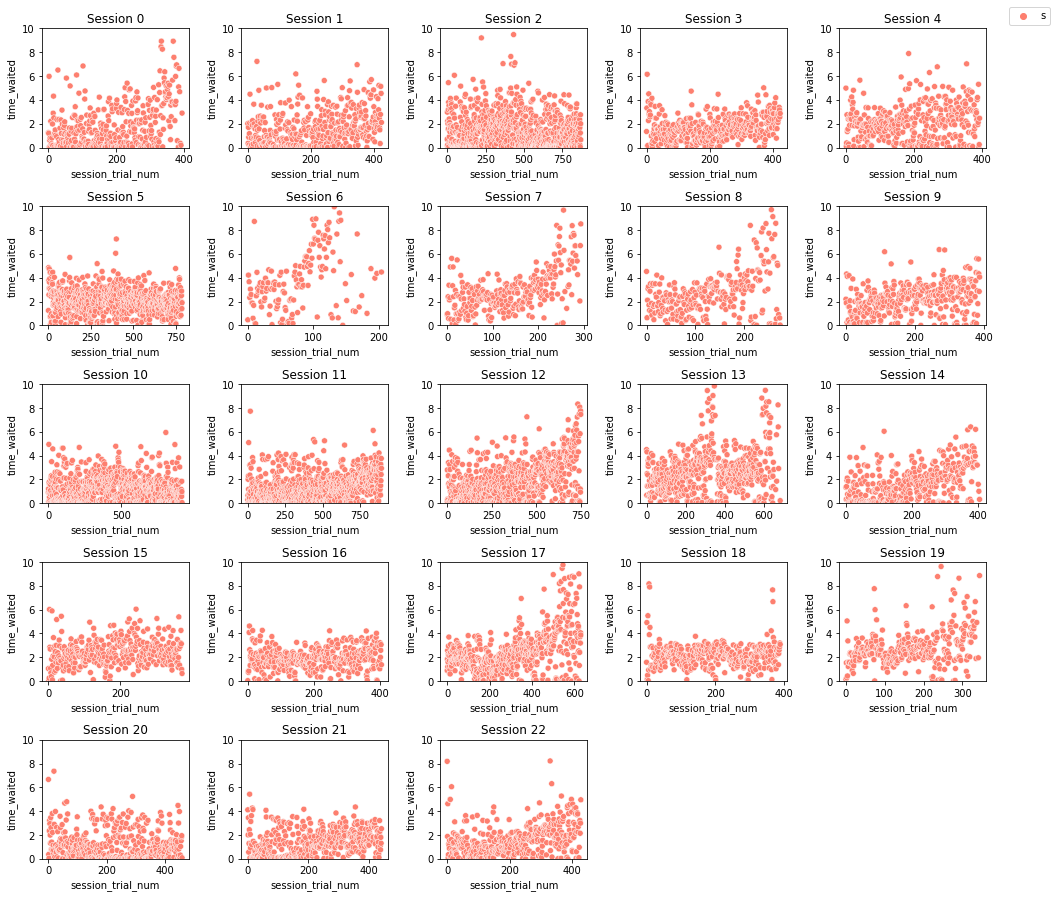

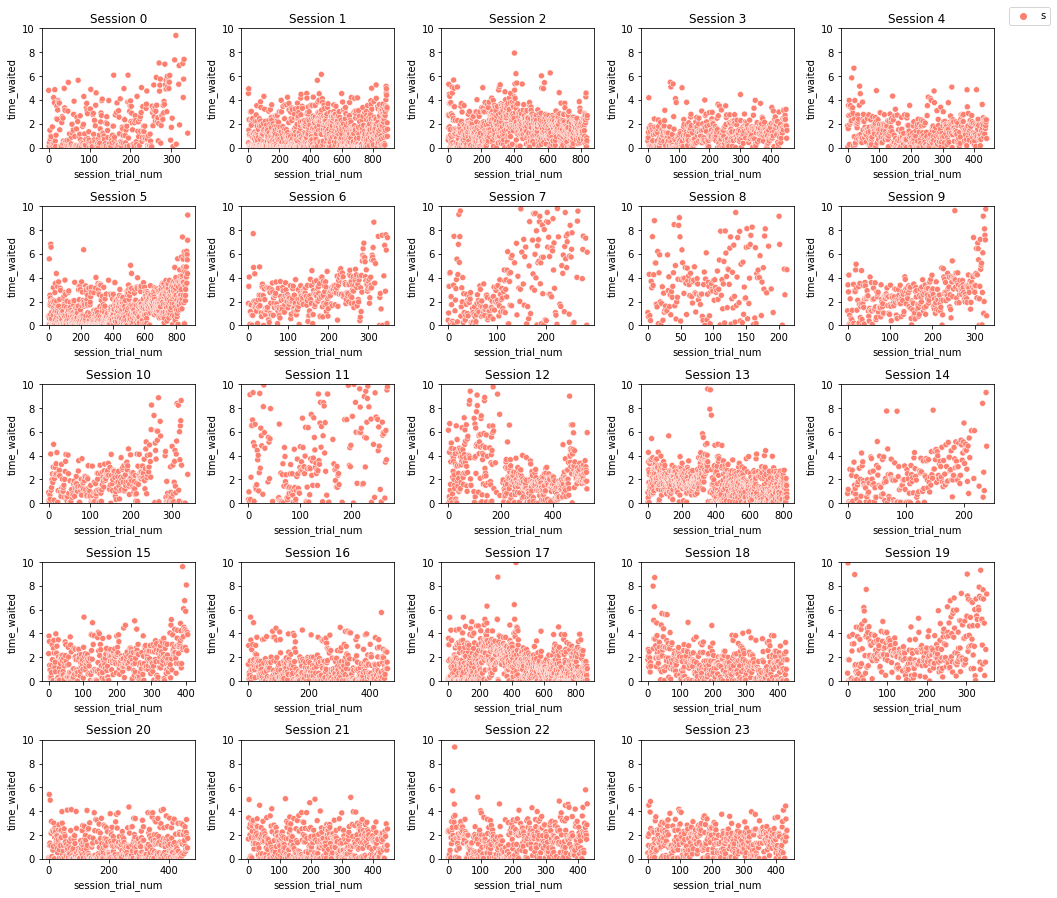

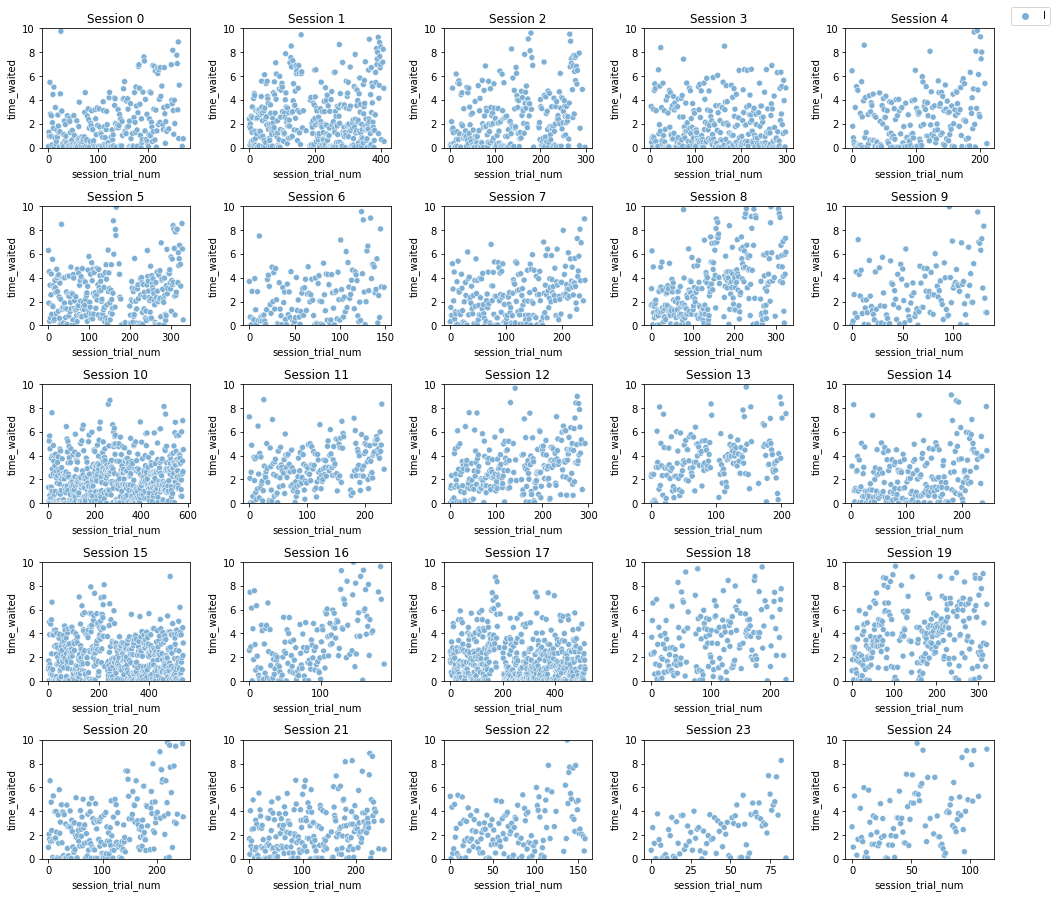

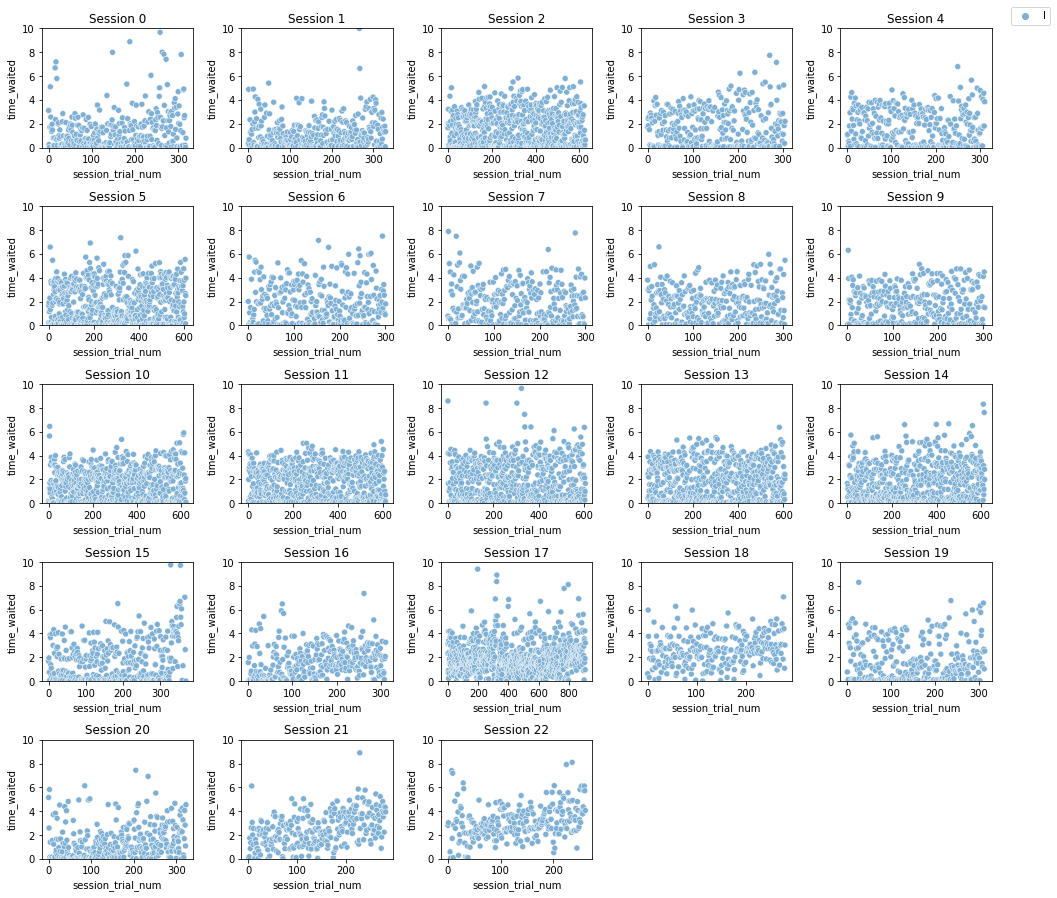

In [46]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, sess) in enumerate(zip(session_mouse.dir, session_mouse.session_num)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {sess}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

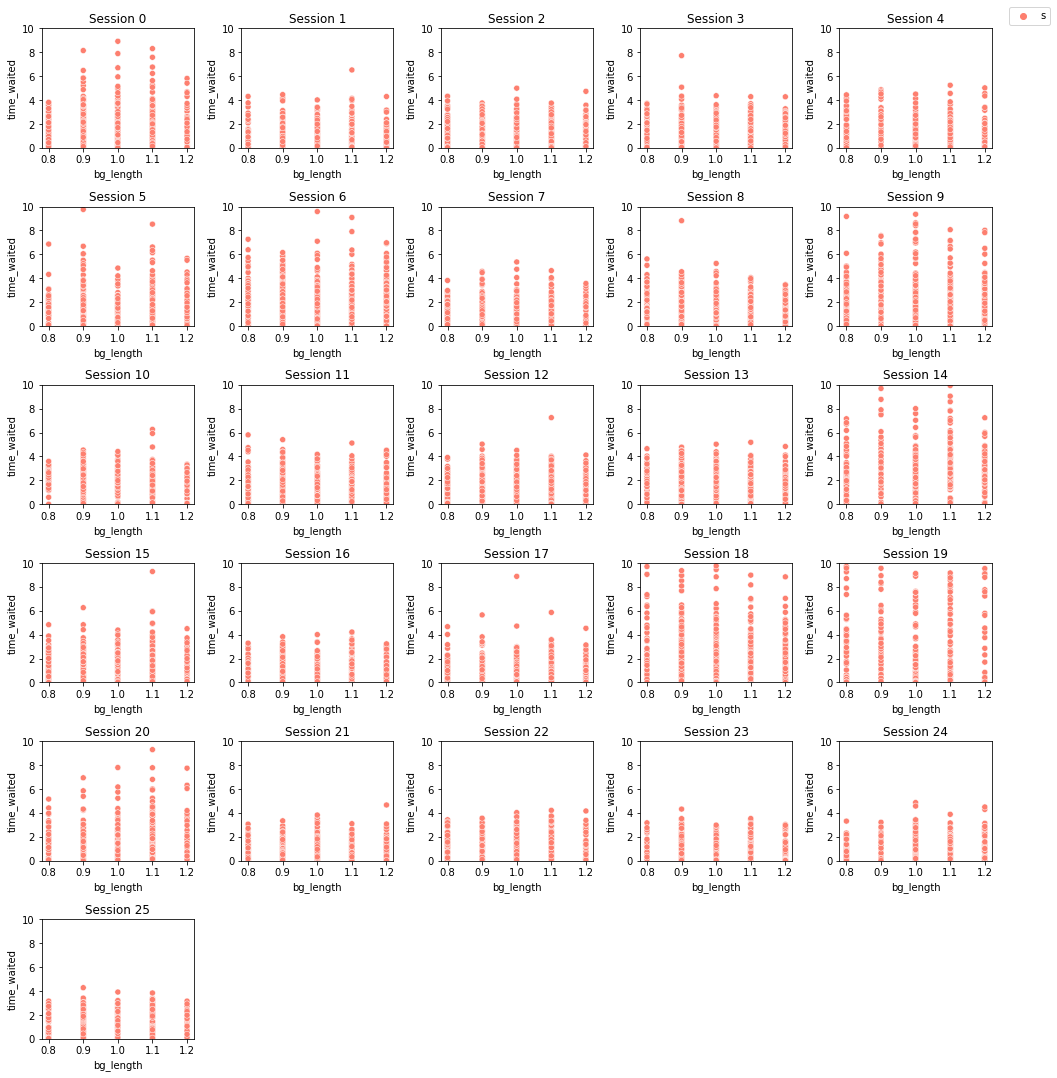

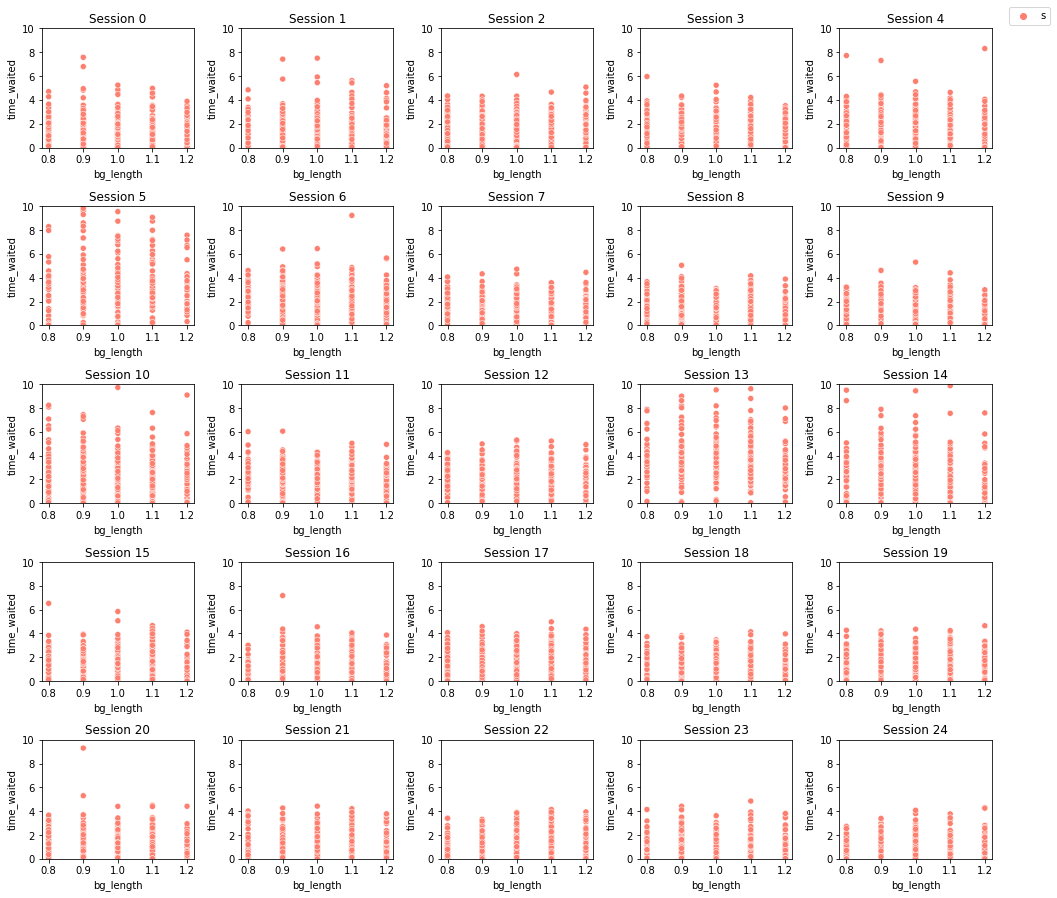

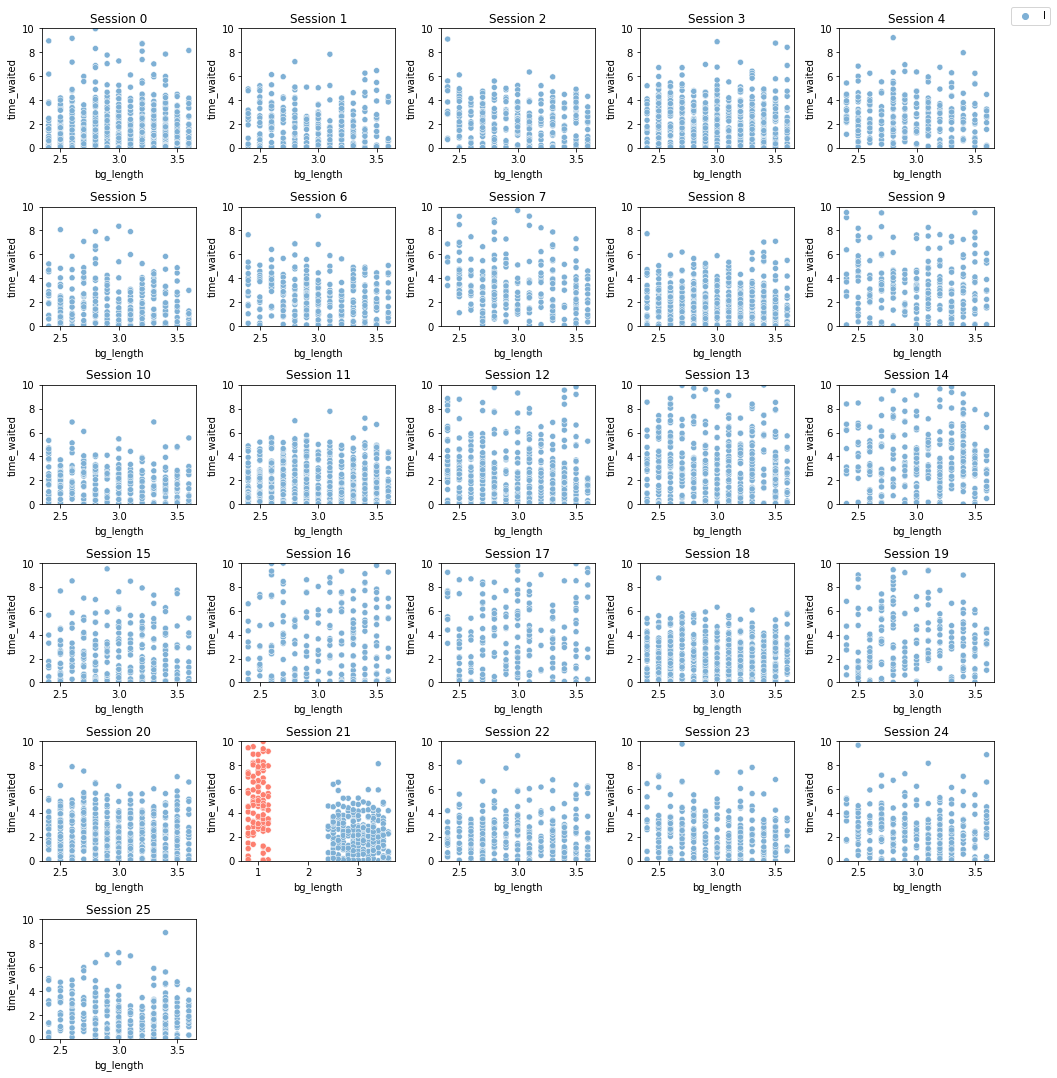

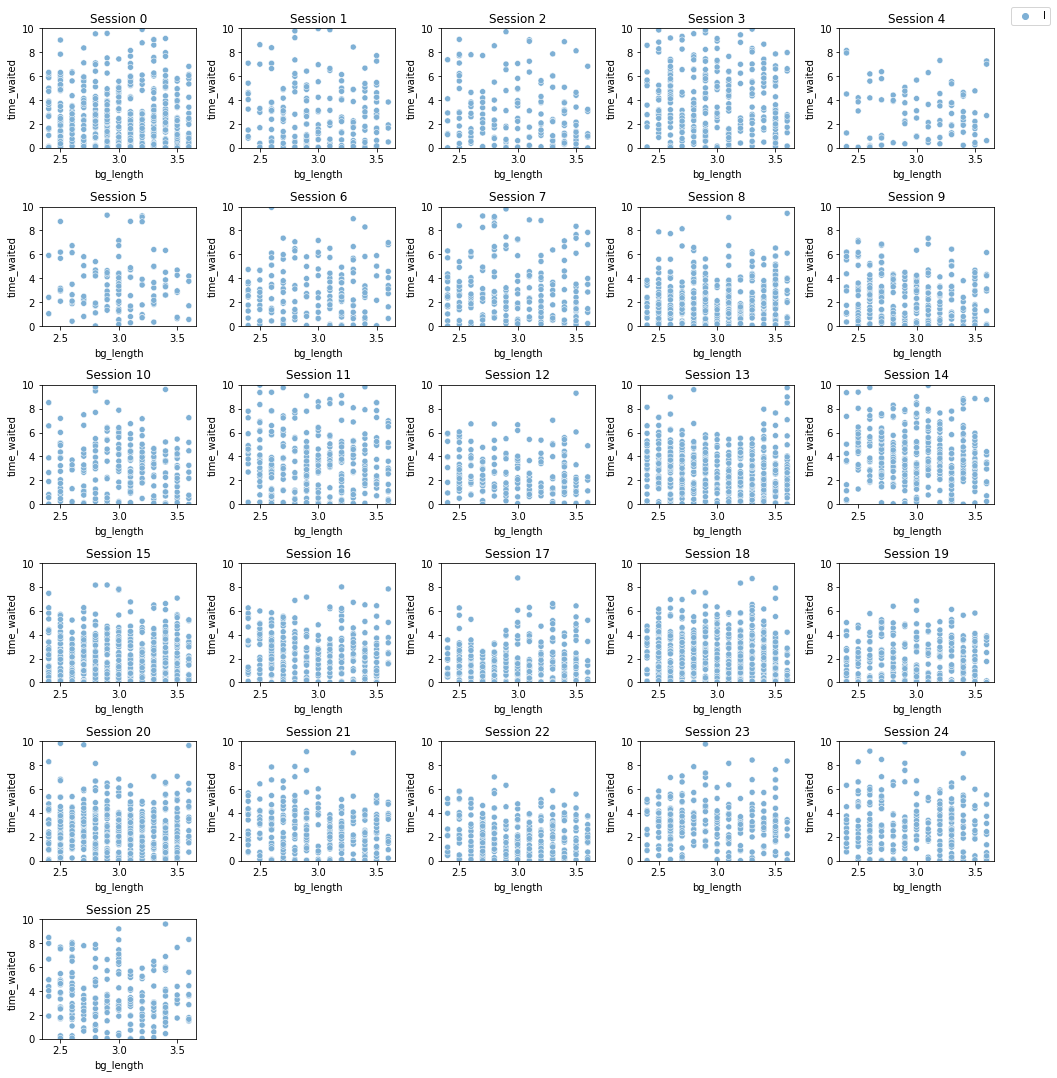

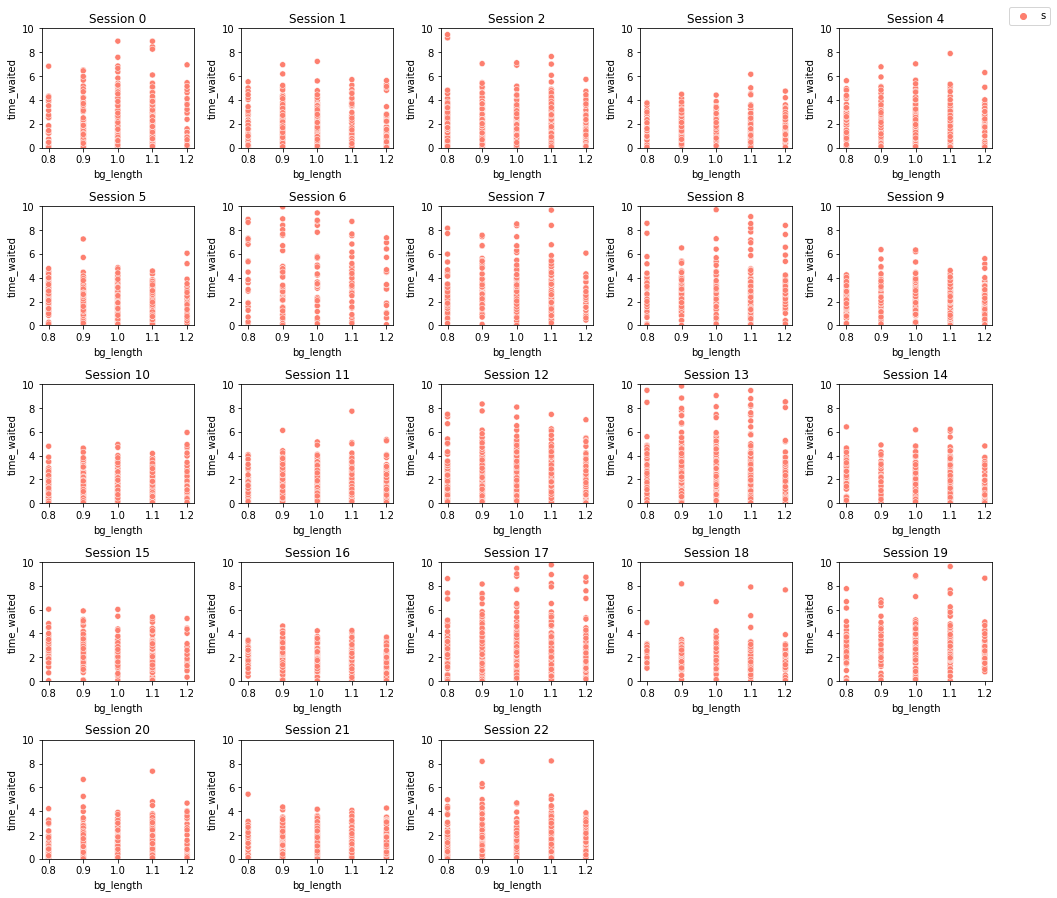

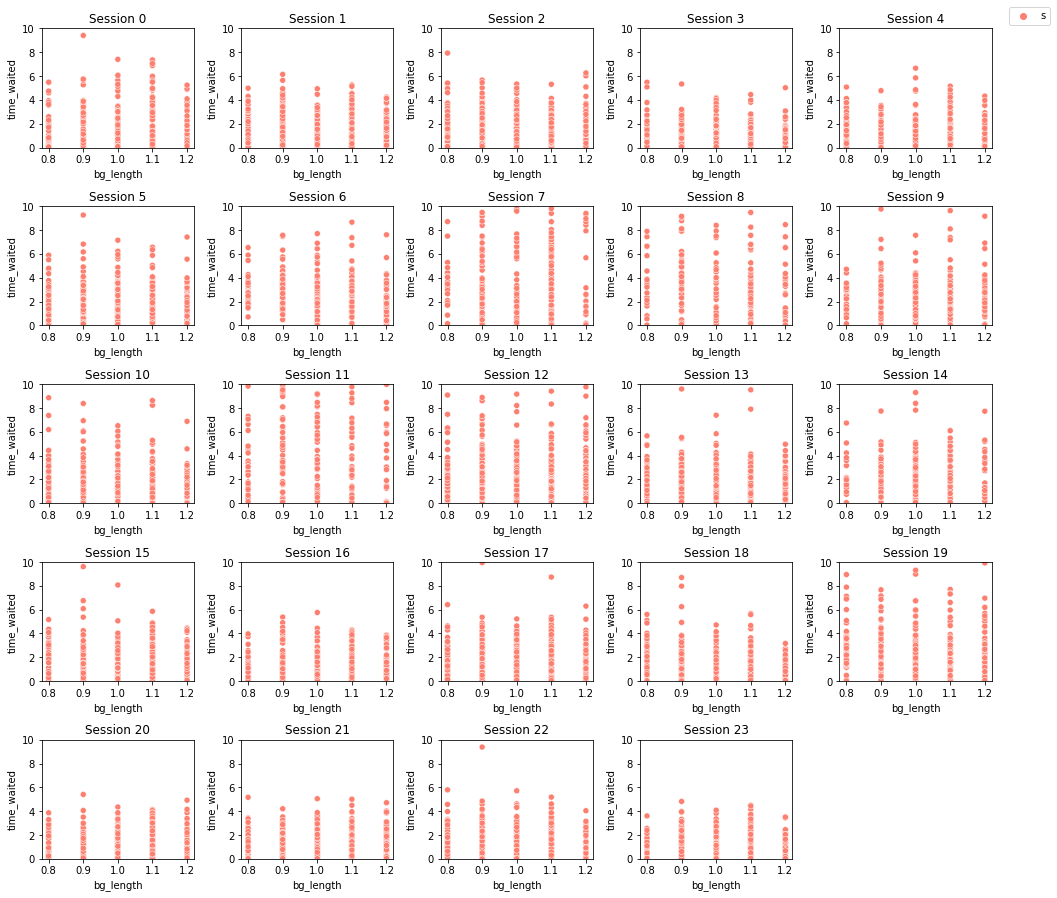

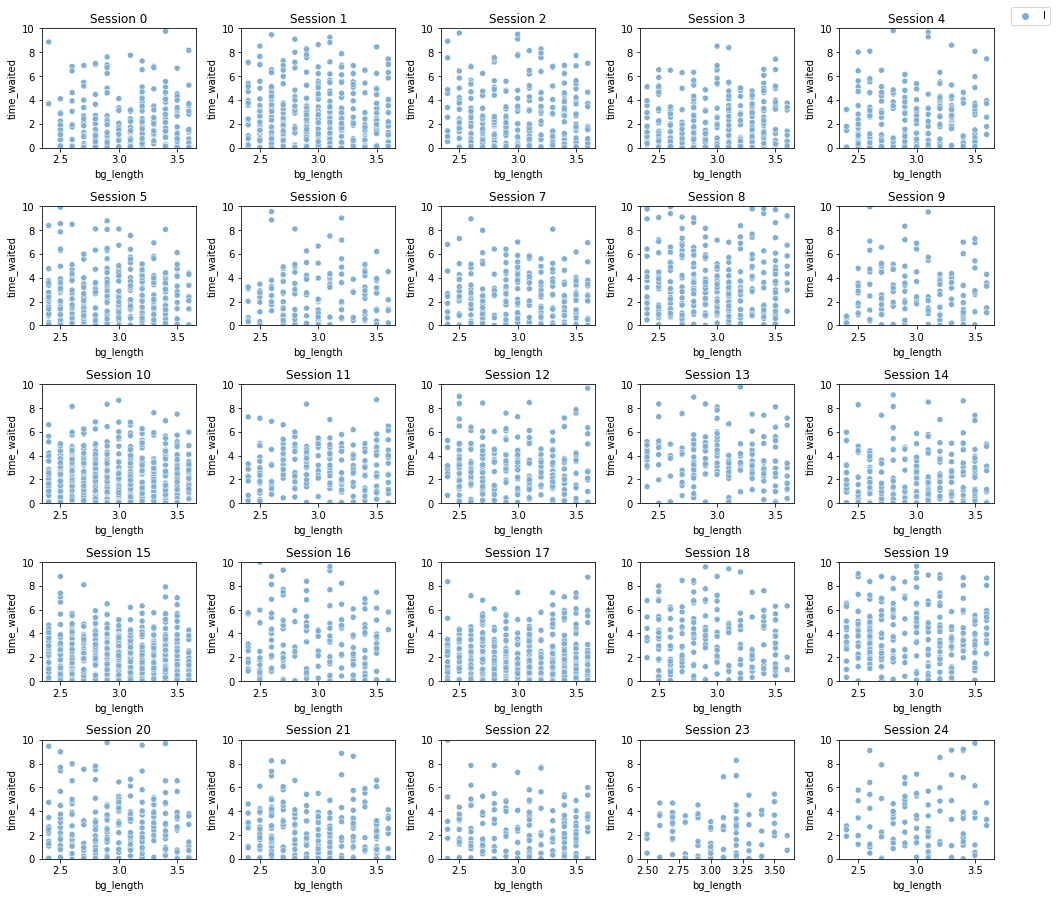

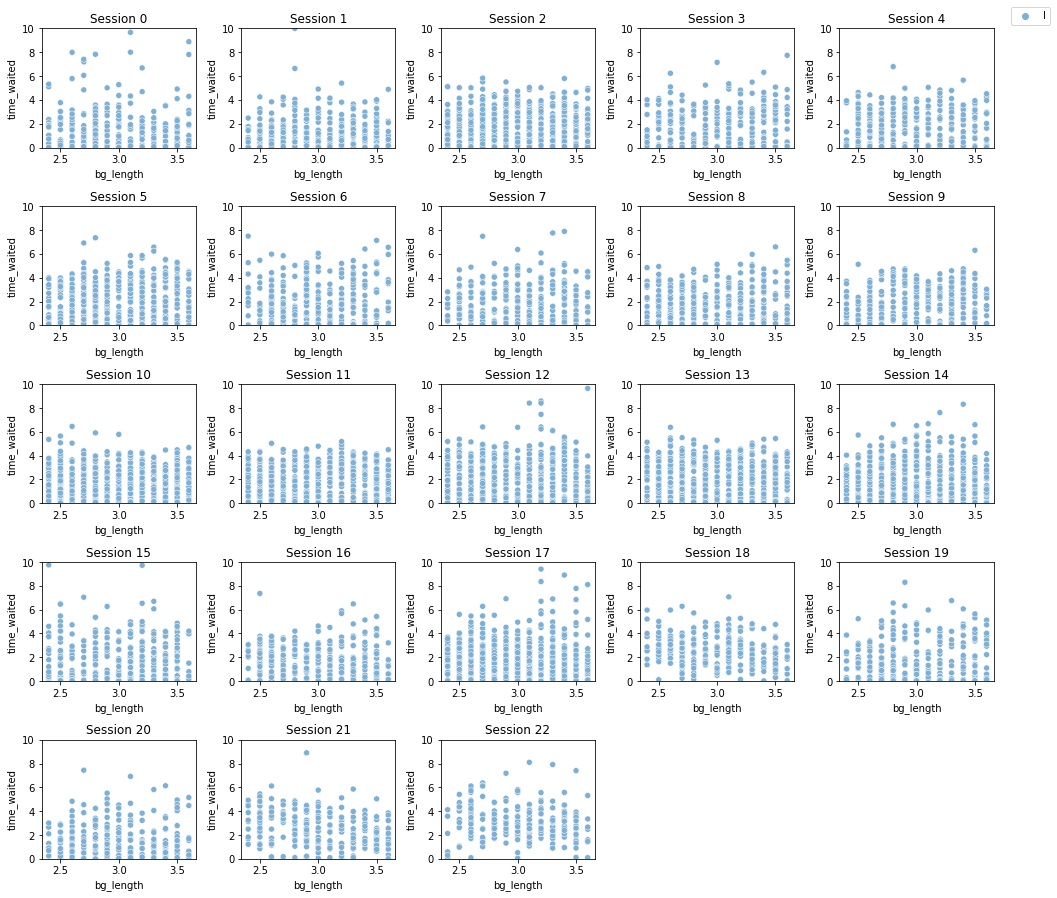

In [47]:
for mouse in mouse_list:
    session_mouse = training_session_log.loc[training_session_log.mouse == mouse]
    days_trained = len(session_mouse)

    # Calculate the number of rows and columns for the subplot grid
    num_rows = (days_trained - 1) // 5 + 1
    num_cols = min(days_trained, 5)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 2.5 * num_rows))

    for i, (dir_name, sess) in enumerate(zip(session_mouse.dir, session_mouse.session_num)):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        custom_palette = {'l': colors[1], 's': colors[0]}
        
        sns.scatterplot(x="bg_length",
                        y="time_waited",
                        hue="blk_type",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_title(f'Session {sess}')
        ax.set_ylim([0, 10])

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    
    for i in range(days_trained):
        ax = axs.flat[i]
        ax.get_legend().remove()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)

In [57]:
# Sample DataFrame
data = {'mouse': ['MouseA', 'MouseA', 'MouseA', 'MouseA', 'MouseA', 'MouseA', 'MouseB', 'MouseB', 'MouseB', 'MouseB'],
        'days': [1, 2, 3, 4, 5, 6, 1, 2, 3, 4]}

df = pd.DataFrame(data)

# Convert 'days' column to datetime for easier sorting
df['days'] = pd.to_datetime(df['days'], format='%d')

# Sort the DataFrame by 'mouse' and 'days' in descending order
df.sort_values(by=['mouse', 'days'], ascending=[True, False], inplace=True)

# Group by 'mouse' and select the first five rows for each group
result = df.groupby('mouse').head(5)

# If you want to reset the index (optional)
result.reset_index(drop=True, inplace=True)

print(result)

    mouse       days
0  MouseA 1900-01-06
1  MouseA 1900-01-05
2  MouseA 1900-01-04
3  MouseA 1900-01-03
4  MouseA 1900-01-02
5  MouseB 1900-01-04
6  MouseB 1900-01-03
7  MouseB 1900-01-02
8  MouseB 1900-01-01


In [72]:
training_session_log.sort_values(by=['mouse', 'session_num'], ascending=[True, False], inplace=True)
last_days_log = training_session_log.groupby('mouse').head(5).copy()

In [73]:
last_days_log.sort_values(by=['mouse', 'session_num'], inplace=True)

In [74]:
last_days_log

date  mouse               dir                             filename  \
161  2023-09-01  RZ018  2023-09-01_RZ018  processed_data_RZ018_2023-09-01.csv   
167  2023-09-05  RZ018  2023-09-05_RZ018  processed_data_RZ018_2023-09-05.csv   
175  2023-09-06  RZ018  2023-09-06_RZ018  processed_data_RZ018_2023-09-06.csv   
182  2023-09-07  RZ018  2023-09-07_RZ018  processed_data_RZ018_2023-09-07.csv   
190  2023-09-08  RZ018  2023-09-08_RZ018  processed_data_RZ018_2023-09-08.csv   
162  2023-09-01  RZ019  2023-09-01_RZ019  processed_data_RZ019_2023-09-01.csv   
168  2023-09-05  RZ019  2023-09-05_RZ019  processed_data_RZ019_2023-09-05.csv   
176  2023-09-06  RZ019  2023-09-06_RZ019  processed_data_RZ019_2023-09-06.csv   
183  2023-09-07  RZ019  2023-09-07_RZ019  processed_data_RZ019_2023-09-07.csv   
191  2023-09-08  RZ019  2023-09-08_RZ019  processed_data_RZ019_2023-09-08.csv   
163  2023-09-01  RZ020  2023-09-01_RZ020  processed_data_RZ020_2023-09-01.csv   
169  2023-09-05  RZ020  2023-09-05_RZ020  processed_data_RZ020_2023-09-05.csv   
177  2023-09-06  RZ020  2023-09-06_RZ020  processed_data_RZ020_2023-09-06.csv   
184  2023-09-07  RZ020  2023-09-07_RZ020  processed_data_RZ020_2023-09-07.csv   
192  2023-09-08  RZ020  2023-09-08_RZ020  processed_data_RZ020_2023-09-08.csv   
164  2023-09-01  RZ021  2023-09-01_RZ021  processed_data_RZ021_2023-09-01.csv   
170  2023-09-05  RZ021  2023-09-05_RZ021  processed_data_RZ021_2023-09-05.csv   
178  2023-09-06  RZ021  2023-09-06_RZ021  processed_data_RZ021_2023-09-06.csv   
185  2023-09-07  RZ021  2023-09-07_RZ021  processed_data_RZ021_2023-09-07.csv   
193  2023-09-08  RZ021  2023-09-08_RZ021  processed_data_RZ021_2023-09-08.csv   
149  2023-08-30  RZ022  2023-08-30_RZ022  processed_data_RZ022_2023-08-30.csv   
157  2023-08-31  RZ022  2023-08-31_RZ022  processed_data_RZ022_2023-08-31.csv   
171  2023-09-05  RZ022  2023-09-05_RZ022  processed_data_RZ022_2023-09-05.csv   
186  2023-09-07  RZ022  2023-09-07_RZ022  processed_data_RZ022_2023-09-07.csv   
194  2023-09-08  RZ022  2023-09-08_RZ022  processed_data_RZ022_2023-09-08.csv   
158  2023-08-31  RZ023  2023-08-31_RZ023  processed_data_RZ023_2023-08-31.csv   
172  2023-09-05  RZ023  2023-09-05_RZ023  processed_data_RZ023_2023-09-05.csv   
179  2023-09-06  RZ023  2023-09-06_RZ023  processed_data_RZ023_2023-09-06.csv   
187  2023-09-07  RZ023  2023-09-07_RZ023  processed_data_RZ023_2023-09-07.csv   
195  2023-09-08  RZ023  2023-09-08_RZ023  processed_data_RZ023_2023-09-08.csv   
165  2023-09-01  RZ024  2023-09-01_RZ024  processed_data_RZ024_2023-09-01.csv   
173  2023-09-05  RZ024  2023-09-05_RZ024  processed_data_RZ024_2023-09-05.csv   
180  2023-09-06  RZ024  2023-09-06_RZ024  processed_data_RZ024_2023-09-06.csv   
188  2023-09-07  RZ024  2023-09-07_RZ024  processed_data_RZ024_2023-09-07.csv   
196  2023-09-08  RZ024  2023-09-08_RZ024  processed_data_RZ024_2023-09-08.csv   
166  2023-09-01  RZ025  2023-09-01_RZ025  processed_data_RZ025_2023-09-01.csv   
174  2023-09-05  RZ025  2023-09-05_RZ025  processed_data_RZ025_2023-09-05.csv   
181  2023-09-06  RZ025  2023-09-06_RZ025  processed_data_RZ025_2023-09-06.csv   
189  2023-09-07  RZ025  2023-09-07_RZ025  processed_data_RZ025_2023-09-07.csv   
197  2023-09-08  RZ025  2023-09-08_RZ025  processed_data_RZ025_2023-09-08.csv   

     num_sessions  num_blocks  num_trials  rewards     time  proper_end  \
161             1         1.0       483.0    144.2  2401.92        True   
167             1         1.0       451.0    283.5  2402.59        True   
175             1         1.0       487.0    180.6  2404.52        True   
182             1         1.0       476.0    191.1  2403.66        True   
190             1         1.0       457.0    229.2  2405.16        True   
162             1         1.0       447.0    256.1  2400.11        True   
168             1         1.0       472.0    241.3  2402.95        True   
176             1         1.0       474.0    216.3  2405.77        True   
183           

# Stitched all sessions all mice per day

In [13]:
cohort = 'cohort_3'
to_analyze = 'full_clean_stitched_all_mice'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'figures_stitched_all_mice')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/full_clean_stitched_all_mice
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/figures_stitched_all_mice


In [14]:
stitched_log = utils.load_session_log(data_folder, 'stitched_all_mice_training_sessions.csv')

In [15]:
stitched_log

date                       filename  num_sessions  num_blocks  \
0   2023-07-25  processed_data_2023-07-25.csv             4        10.0   
1   2023-07-26  processed_data_2023-07-26.csv             8         8.0   
2   2023-07-27  processed_data_2023-07-27.csv             8        12.0   
3   2023-07-28  processed_data_2023-07-28.csv             8        16.0   
4   2023-07-30  processed_data_2023-07-30.csv             8         8.0   
5   2023-07-31  processed_data_2023-07-31.csv             8         8.0   
6   2023-08-01  processed_data_2023-08-01.csv             8        14.0   
7   2023-08-02  processed_data_2023-08-02.csv             8         8.0   
8   2023-08-03  processed_data_2023-08-03.csv             8        12.0   
9   2023-08-04  processed_data_2023-08-04.csv             7        10.0   
10  2023-08-05  processed_data_2023-08-05.csv             8         8.0   
11  2023-08-07  processed_data_2023-08-07.csv             8        16.0   
12  2023-08-08  processed_data_2023-08-08.csv             8        15.0   
13  2023-08-09  processed_data_2023-08-09.csv             8        17.0   
14  2023-08-10  processed_data_2023-08-10.csv             8        17.0   
15  2023-08-24  processed_data_2023-08-24.csv             7         8.0   
16  2023-08-25  processed_data_2023-08-25.csv             7         8.0   
17  2023-08-28  processed_data_2023-08-28.csv             8         9.0   
18  2023-08-29  processed_data_2023-08-29.csv             8        16.0   
19  2023-08-30  processed_data_2023-08-30.csv             8         9.0   
20  2023-08-31  processed_data_2023-08-31.csv             8        13.0   
21  2023-09-01  processed_data_2023-09-01.csv             6         7.0   
22  2023-09-05  processed_data_2023-09-05.csv             8         8.0   
23  2023-09-06  processed_data_2023-09-06.csv             7         7.0   
24  2023-09-07  processed_data_2023-09-07.csv             8         8.0   
25  2023-09-08  processed_data_2023-09-08.csv             8         8.0   

    num_trials  rewards      time  proper_end  days  
0       3393.0   3684.0  21927.50        True     0  
1       2831.0   3848.6  19119.26        True     1  
2       4423.0   4749.1  27605.16        True     2  
3       5359.0   7004.1  35472.89        True     3  
4       2710.0   3650.1  17797.25        True     4  
5       2489.0   4306.0  17342.83        True     5  
6       4659.0   7315.3  31381.90        True     6  
7       2389.0   4639.5  17709.61        True     7  
8       3918.0   5530.1  27004.27        True     8  
9       2821.0   6080.7  20975.22        True     9  
10      2572.0   4256.1  18022.92        True    10  
11      5066.0   7208.4  34657.36        True    11  
12      4372.0   6343.5  29869.08        True    12  
13      4803.0   9627.8  35259.38        True    13  
14      4119.0  10554.2  32097.59        True    14  
15      2587.0   4529.9  18413.22        True    15  
16      2734.0   4450.3  18579.47        True    16  
17      3135.0   4090.1  20996.06        True    17  
18      5234.0   7543.6  35224.57        True    18  
19      2670.0   4517.5  19234.17        True    19  
20      3920.0   7538.8  29920.18        True    20  
21      2206.0   3620.5  16100.45        True    21  
22      3011.0   3267.1  19193.64        True    22  
23      2443.0   2990.2  16004.85        True    23  
24      2739.0   3445.5  17704.35        True    24  
25      2688.0   3838.5  17888.35        True    25

In [16]:
def generate_stitched_all_mice_all_trials_path(data_folder, d):
    return os.path.join(data_folder, d, f'{d}_all_trials_analyzed.csv')

In [17]:
def load_stitched_all_trials_all_mice_analyzed(data_folder, d):
    path = generate_stitched_all_mice_all_trials_path(data_folder, d)
    all_trials_analyzed_df = pd.read_csv(path, index_col=0)
    return all_trials_analyzed_df

In [18]:
def generate_stitched_wait_df(training_session_log):
    wait_df = training_session_log[['date', 'days']].copy()

    for d in training_session_log.date:
        all_trials = load_stitched_all_trials_all_mice_analyzed(data_folder, d)
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.date == d, 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.date == d, 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [19]:
wait_df = generate_stitched_wait_df(stitched_log)

In [20]:
wait_df

date  days   tw_mean  tw_median  tw_stdev  tw_mean_g  tw_median_g  \
0   2023-07-25     0  1.505633   1.046668  1.575203   2.138177     1.718684   
1   2023-07-26     1  1.672925   1.163982  1.721978   2.375775     1.919957   
2   2023-07-27     2  1.548333   1.274231  1.479687   2.171827     1.877328   
3   2023-07-28     3  1.794451   1.599175  1.543431   2.288879     1.987486   
4   2023-07-30     4  1.803080   1.566042  1.441065   2.208455     1.923249   
5   2023-07-31     5  2.056153   1.784132  1.734703   2.531715     2.179293   
6   2023-08-01     6  2.046868   1.928870  1.436263   2.387940     2.172427   
7   2023-08-02     7  2.320550   1.970508  1.797713   2.651730     2.227272   
8   2023-08-03     8  1.927768   1.650126  1.568847   2.279574     1.923441   
9   2023-08-04     9  2.380607   1.978354  1.919756   2.801013     2.373602   
10  2023-08-05    10  2.122951   1.994978  1.484253   2.462782     2.255770   
11  2023-08-07    11  1.853113   1.594203  1.550090   2.311210     1.988485   
12  2023-08-08    12  1.957901   1.746285  1.577151   2.355596     2.066967   
13  2023-08-09    13  2.349019   2.158531  1.641620   2.668555     2.384752   
14  2023-08-10    14  2.718713   2.513275  1.853013   3.044190     2.742976   
15  2023-08-24    15  2.049572   1.799991  1.693306   2.565550     2.276551   
16  2023-08-25    16  1.989172   1.710150  1.633907   2.421770     2.104136   
17  2023-08-28    17  1.729212   1.365290  1.629251   2.246661     1.824602   
18  2023-08-29    18  1.817883   1.496706  1.600148   2.332652     1.979110   
19  2023-08-30    19  2.123575   1.762804  1.830940   2.544057     2.109497   
20  2023-08-31    20  2.267510   2.014128  1.661192   2.592722     2.249517   
21  2023-09-01    21  2.027459   1.635995  1.740471   2.479518     2.069979   
22  2023-09-05    22  1.522443   1.174002  1.412519   2.075011     1.698132   
23  2023-09-06    23  1.613567   1.275735  1.535841   2.253814     1.956655   
24  2023-09-07    24  1.718334   1.451590  1.467374   2.197253     1.911938   
25  2023-09-08    25  1.898965   1.638525  1.542850   2.268033     1.955074   

    tw_stdev_g  
0     1.556345  
1     1.673847  
2     1.376567  
3     1.432155  
4     1.328237  
5     1.623690  
6     1.296287  
7     1.706793  
8     1.485241  
9     1.811611  
10    1.341968  
11    1.436314  
12    1.472444  
13    1.512137  
14    1.712441  
15    1.551604  
16    1.524145  
17    1.566417  
18    1.494666  
19    1.750571  
20    1.549425  
21    1.646225  
22    1.318531  
23    1.427088  
24    1.353869  
25    1.453033

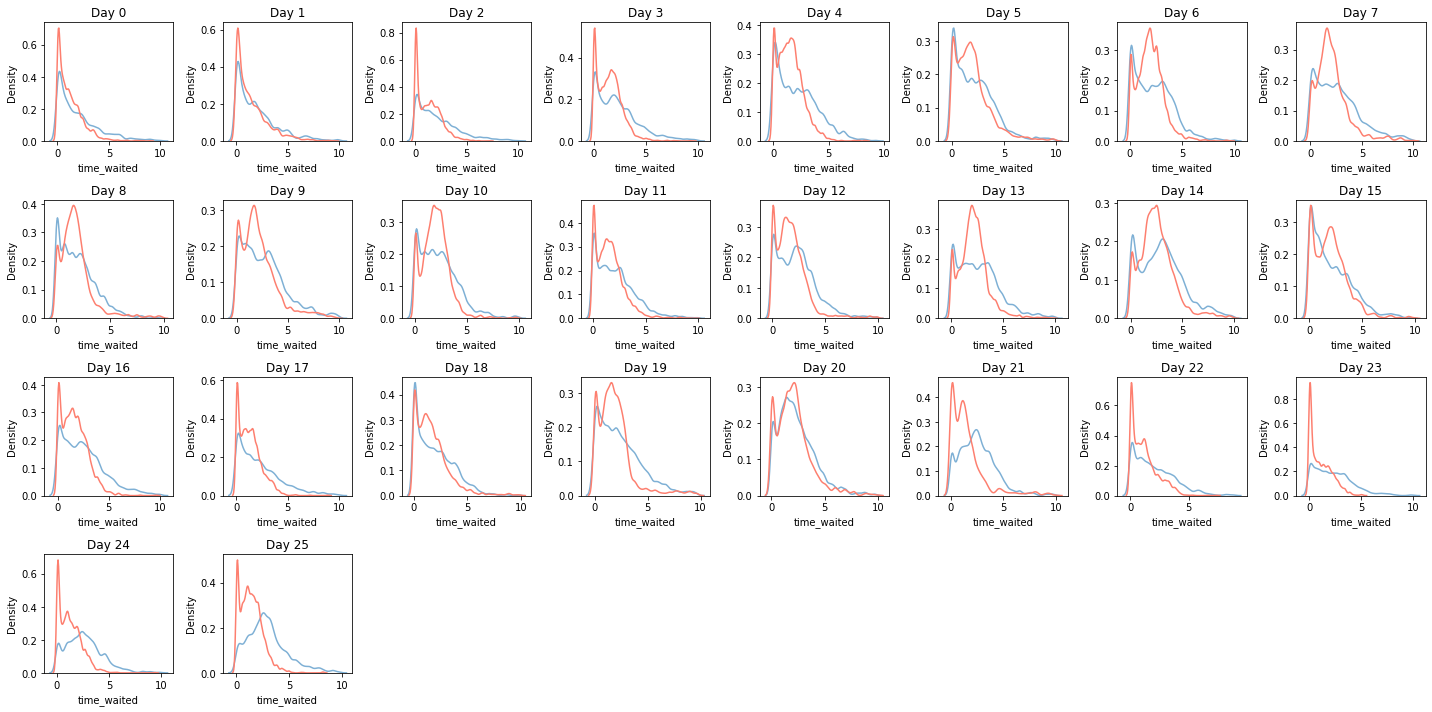

In [24]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (d, day) in enumerate(zip(stitched_log.date, stitched_log.days)):
    all_trials = load_stitched_all_trials_all_mice_analyzed(data_folder, d)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="blk_type",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.set_title(f'Day {day}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_kde_{d}.png', bbox_inches='tight', dpi=300)

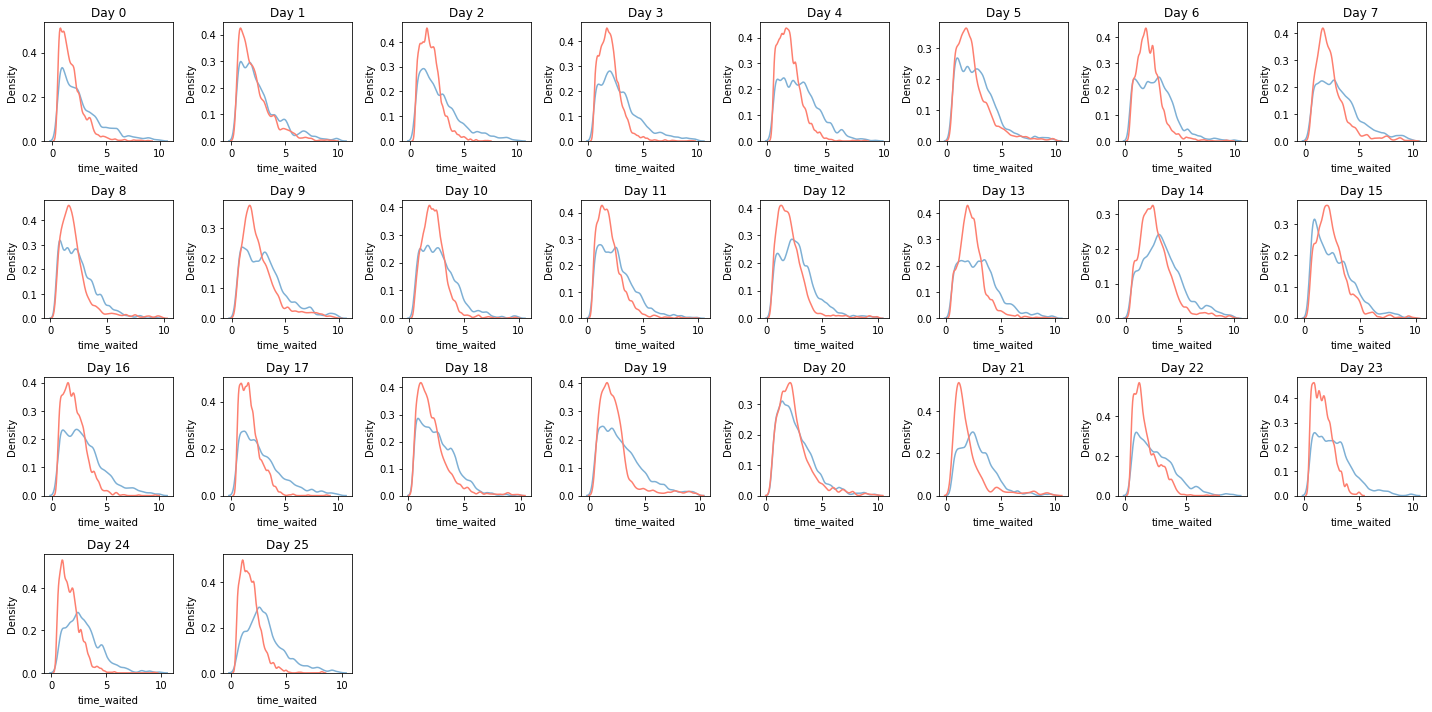

In [23]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 8 + 1
num_cols = min(days_trained, 8)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 2.5 * num_rows))

for i, (d, day) in enumerate(zip(stitched_log.date, stitched_log.days)):
    all_trials = load_stitched_all_trials_all_mice_analyzed(data_folder, d)
    good_trials = utils.select_good_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=good_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="blk_type",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.set_title(f'Day {day}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{figure_folder}/tw_g_kde_{d}.png', bbox_inches='tight', dpi=300)

In [17]:
# cohort = 'cohort_2'
to_analyze = 'full_clean_analyzed'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
# figure_folder = os.path.join(data_dir, cohort, 'figures')
# data_folder = os.path.join(data_dir, cohort, to_analyze)
# print(data_folder)
# print(figure_folder)

In [20]:
v1_data_folder = os.path.join(data_dir, 'cohort_1', 'full_clean')
v2_data_folder = os.path.join(data_dir, 'cohort_2', 'full_clean_analyzed')
v3_data_folder = os.path.join(data_dir, 'cohort_2_v2', 'full_clean')

In [23]:
v1_wait = utils.load_session_log(v1_data_folder, 'wait.csv')
v2_wait = utils.load_session_log(v2_data_folder, 'wait.csv')
v3_wait = utils.load_session_log(v3_data_folder, 'wait.csv')

In [39]:
v1_l = v1_wait.tw_l_mean.mean()
v2_l = v2_wait.tw_l_mean.mean()
v3_l = v3_wait.tw_l_mean.mean()

v1_s = v1_wait.tw_s_mean.mean()
v2_s = v2_wait.tw_s_mean.mean()
v3_s = v3_wait.tw_s_mean.mean()

In [40]:
wait_time_l = [v1_l, v2_l, v3_l]
wait_time_s = [v1_s, v2_s, v3_s]

In [41]:
sum(wait_time_l)/3

1.501952193711585

In [42]:
sum(wait_time_s)/3

1.621940462372651